# REACH Random Forest Classifier Training

## Data Visualization

In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

In [28]:
sample_file_path ="reach-emg-data-master-folder/REACH EMG Data 1_24 LABELLED/Michael_Curl_Extend_1_24.csv"
df = pd.read_csv(sample_file_path)
df.head()

,channel1,channel2,Audio Trigger,class
0,-0.014496,-0.016785,0.007019,0
1,-0.015411,0.058136,0.006409,0
2,-0.014496,0.110321,0.007019,0
3,-0.015411,0.065460,0.003357,0
4,-0.015411,0.032196,0.006714,0


In [29]:
# Define a colormap for different classes
class_colors = {
    0: "gray",   # Rest
    1: "blue",   # Grasp
    2: "cyan",   # Release
    3: "green",  # Curl
    4: "lime",   # Extend
    5: "orange", # Jaw
    6: "yellow", # Pinch
    7: "red",    # Thumb Down
    8: "purple"  # Thumb Up
}

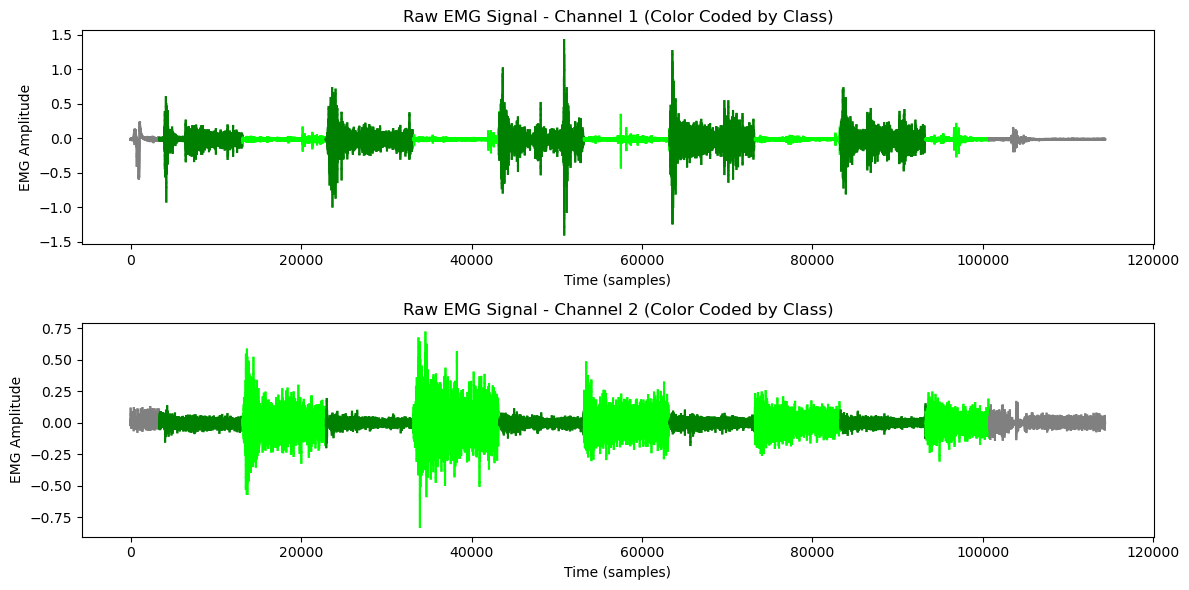

In [30]:
# Create figure
plt.figure(figsize=(12, 6))

# Plot Channel 1 with color changes based on class labels
plt.subplot(2, 1, 1)
for i in range(len(df) - 1):
    plt.plot([i, i+1], [df["channel1"][i], df["channel1"][i+1]], 
             color=class_colors[df["class"][i]])
plt.xlabel("Time (samples)")
plt.ylabel("EMG Amplitude")
plt.title("Raw EMG Signal - Channel 1 (Color Coded by Class)")

# Plot Channel 2 with color changes based on class labels
plt.subplot(2, 1, 2)
for i in range(len(df) - 1):
    plt.plot([i, i+1], [df["channel2"][i], df["channel2"][i+1]], 
             color=class_colors[df["class"][i]])
plt.xlabel("Time (samples)")
plt.ylabel("EMG Amplitude")
plt.title("Raw EMG Signal - Channel 2 (Color Coded by Class)")

plt.tight_layout()
plt.show()

## Data Preprocessing

In [31]:
import glob

# Define the master folder path
master_folder = "reach-emg-data-master-folder"

# Find all CSV files in subdirectories
csv_files = glob.glob(f"{master_folder}/**/*.csv", recursive=True)

# Print the number of files found
print(f"Found {len(csv_files)} CSV files.")

# Load each file into a DataFrame and store in a list
dataframes = []
for file in csv_files:
    df = pd.read_csv(file)  # Load CSV
    df["source_file"] = file  # Keep track of source for debugging
    #drop audio
    df.drop(columns=["Audio Trigger"], inplace=True)
    dataframes.append(df)

# Display an example DataFrame
dataframes[0].head()

Found 84 CSV files.


,channel1,channel2,class,source_file
0,-0.014496,-0.016785,0,reach-emg-data-master-folder\REACH EMG Data 1_...
1,-0.015411,0.058136,0,reach-emg-data-master-folder\REACH EMG Data 1_...
2,-0.014496,0.110321,0,reach-emg-data-master-folder\REACH EMG Data 1_...
3,-0.015411,0.065460,0,reach-emg-data-master-folder\REACH EMG Data 1_...
4,-0.015411,0.032196,0,reach-emg-data-master-folder\REACH EMG Data 1_...


In [32]:
# Define the sampling frequency (adjust if needed)
fs = 1000.0

In [33]:
from collections import Counter, defaultdict

# Dictionary to store properly segmented data
segmented_data_by_subject = defaultdict(list)

# Process each subject
for subject_id in range(len(csv_files) // 4):
    subject_files = csv_files[subject_id * 4 : (subject_id + 1) * 4]  # Get 4 files per subject

    for file in subject_files:
        # Find corresponding filtered dataframe
        df = next(df for df in dataframes if df["source_file"].iloc[0] == file)

        # Drop the source_file column
        df = df.drop(columns=["source_file"])

        # Split the data whenever the label changes
        start_idx = 0
        for i in range(1, len(df)):
            if df["class"].iloc[i] != df["class"].iloc[i - 1]:
                # Capture the segment and store it
                segment = df.iloc[start_idx:i].copy()
                segmented_data_by_subject[subject_id].append(segment)
                start_idx = i  # Update start index
        
        # Capture the last segment
        segment = df.iloc[start_idx:].copy()
        segmented_data_by_subject[subject_id].append(segment)

# Print summary
print(f"Segmented data for {len(segmented_data_by_subject)} subjects.")

# Verify segmentation by printing class distributions
class_counts_by_subject = {subject_id: Counter(segment["class"].iloc[0] for segment in segments)
                           for subject_id, segments in segmented_data_by_subject.items()}

Segmented data for 21 subjects.


In [34]:
from collections import Counter

# Dictionary to store class counts per subject
class_counts_by_subject = {}

# Counter for total class occurrences
total_class_counts = Counter()

# Loop through subjects and count class occurrences
for subject_id, segments in segmented_data_by_subject.items():
    class_counts = Counter(segment["class"].iloc[0] for segment in segments)  # Count classes in this subject
    class_counts_by_subject[subject_id] = class_counts
    
    # Update total class counts
    total_class_counts.update(class_counts)

# Print class counts per subject
for subject_id, class_counts in class_counts_by_subject.items():
    print(f"Subject {subject_id}: {dict(class_counts)}")

# Print total class counts across all subjects
print("\nTotal class occurrences across all subjects:", dict(total_class_counts))

Subject 0: {0: 8, 3: 5, 4: 5, 1: 5, 2: 5, 5: 5, 6: 5, 7: 5, 8: 5}
Subject 1: {0: 8, 3: 5, 4: 5, 1: 5, 2: 5, 5: 5, 6: 5, 7: 5, 8: 5}
Subject 2: {0: 8, 3: 5, 4: 5, 1: 5, 2: 5, 5: 5, 6: 5, 7: 5, 8: 5}
Subject 3: {0: 8, 3: 5, 4: 5, 1: 5, 2: 5, 5: 5, 6: 5, 7: 5, 8: 5}
Subject 4: {0: 8, 3: 5, 4: 5, 1: 5, 2: 5, 5: 5, 6: 5, 7: 5, 8: 5}
Subject 5: {0: 8, 3: 5, 4: 5, 1: 5, 2: 5, 5: 5, 6: 5, 7: 5, 8: 5}
Subject 6: {0: 8, 3: 5, 4: 5, 1: 5, 2: 5, 5: 5, 6: 5, 7: 5, 8: 5}
Subject 7: {0: 8, 3: 5, 4: 5, 1: 5, 2: 5, 5: 5, 6: 5, 7: 5, 8: 5}
Subject 8: {0: 8, 3: 5, 4: 5, 1: 5, 2: 5, 5: 5, 6: 5, 7: 5, 8: 5}
Subject 9: {0: 8, 3: 5, 4: 5, 1: 5, 2: 5, 5: 5, 6: 5, 7: 5, 8: 5}
Subject 10: {0: 8, 3: 5, 4: 5, 1: 5, 2: 5, 5: 5, 6: 5, 7: 5, 8: 5}
Subject 11: {0: 8, 3: 5, 4: 5, 1: 5, 2: 5, 5: 5, 6: 5, 7: 5, 8: 5}
Subject 12: {0: 8, 3: 5, 4: 5, 1: 5, 2: 5, 5: 5, 6: 5, 7: 5, 8: 5}
Subject 13: {0: 8, 3: 5, 4: 5, 1: 5, 2: 5, 5: 5, 6: 5, 7: 5, 8: 5}
Subject 14: {0: 8, 3: 5, 4: 5, 1: 5, 2: 5, 5: 5, 6: 5, 7: 5, 8: 5}
Subje

In [35]:
def extract_sliding_windows(segmented_data, window_size=500, stride=100):
    """
    Extracts sliding windows from segmented data.
    
    Args:
        segmented_data (dict): Segmented data by subject.
        window_size (int): Number of samples in each window.
        stride (int): Step size between consecutive windows.
    
    Returns:
        list: A list of tuples where each tuple is (window_data, window_label).
    """
    sliding_windows = []

    for subject, segments in segmented_data.items():
        for segment in segments:
            segment_label = segment["class"].iloc[0]  # Label for the whole segment
            segment_data = segment.drop(columns=["class"]).values  # Drop label column
            
            # Generate sliding windows
            for start_idx in range(0, len(segment_data) - window_size + 1, stride):
                window = segment_data[start_idx : start_idx + window_size]
                sliding_windows.append((window, segment_label))

    print(f"Extracted {len(sliding_windows)} windows.")
    return sliding_windows

In [36]:
# Set window size and stride
window_size = 500  # 500 samples (~500ms)
stride = 100       # 100-sample step size (~100ms overlap)

# Extract sliding windows from the segmented data
sliding_windows = extract_sliding_windows(segmented_data_by_subject, window_size, stride)

# Print an example window shape and label
example_window, example_label = sliding_windows[0]
print(f"Example Window Shape: {example_window.shape}, Label: {example_label}")

Extracted 89321 windows.
Example Window Shape: (500, 2), Label: 0


Window Shape: (500, 2) (Rows: Timepoints, Columns: Channels)
Class Label: 0


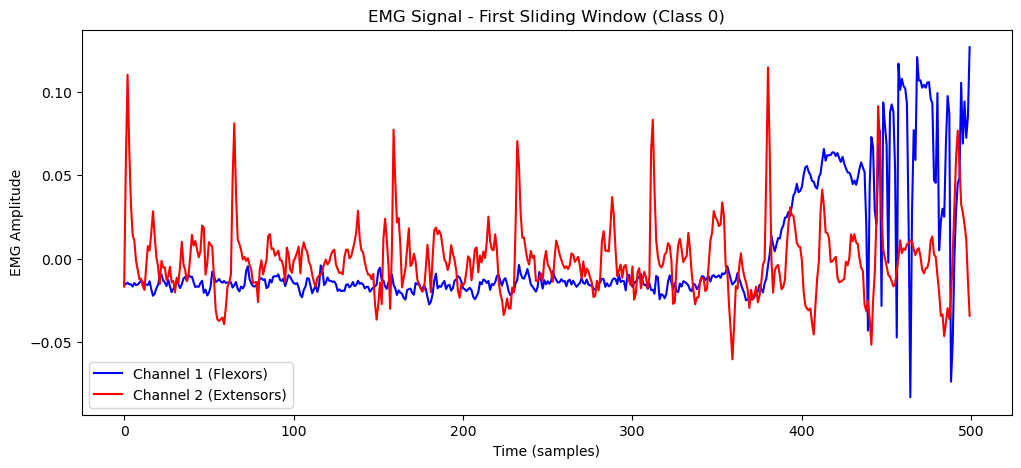

In [37]:
# Select the first window
window_data, window_label = sliding_windows[0]

# Convert to DataFrame for better visualization
window_df = pd.DataFrame(window_data, columns=["channel1", "channel2"])

# Print metadata
print(f"Window Shape: {window_df.shape} (Rows: Timepoints, Columns: Channels)")
print(f"Class Label: {window_label}")

# Plot the windowed EMG signals
plt.figure(figsize=(12, 5))

plt.plot(window_df.index, window_df["channel1"], label="Channel 1 (Flexors)", color="blue")
plt.plot(window_df.index, window_df["channel2"], label="Channel 2 (Extensors)", color="red")

plt.xlabel("Time (samples)")
plt.ylabel("EMG Amplitude")
plt.title(f"EMG Signal - First Sliding Window (Class {window_label})")
plt.legend()
plt.show()

## Training

In [38]:
# Convert list of tuples into NumPy arrays
X = np.array([window[0] for window in sliding_windows])  # Features
y = np.array([window[1] for window in sliding_windows])  # Labels

# Print dataset shapes
print(f"Feature Set Shape: {X.shape}")  # Should be (num_windows, 500, 2)
print(f"Label Set Shape: {y.shape}")    # Should be (num_windows,)
print(f"Example Label: {y[0]}")

Feature Set Shape: (89321, 500, 2)
Label Set Shape: (89321,)
Example Label: 0


In [39]:
# Flatten each window into a single feature vector
X_rf = X.reshape(X.shape[0], -1)  # Reshape to (89321, 1000)

# Print new shape
print(f"Reshaped Feature Set for RF: {X_rf.shape}")  # Should be (89321, 1000)

Reshaped Feature Set for RF: (89321, 1000)


In [40]:
import tsfel
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

# Load default TSFEL feature configuration
cfg = tsfel.get_features_by_domain()  # Extracts all features by default

In [41]:
# Initialize feature and label lists
X_features = []
labels = []

# Extract TSFEL features
for window_data, window_label in sliding_windows:
    window_df = pd.DataFrame(window_data, columns=[f'channel_{i}' for i in range(window_data.shape[1])])

    # Extract features
    features_df = tsfel.time_series_features_extractor(cfg, window_df, fs=1000, verbose=0)

    # Store features and labels
    X_features.append(features_df.values.flatten())  # Keep original order
    labels.append(window_label)

# Convert to NumPy arrays
X = np.array(X_features)
y = np.array(labels)

# Convert back to DataFrame with correct column names
feature_names = features_df.columns.tolist()  # Get the TSFEL feature names
X_df = pd.DataFrame(X, columns=feature_names)  # Keep the correct names

print(f"Feature matrix shape: {X_df.shape}, Labels shape: {y.shape}")

Feature matrix shape: (89321, 312), Labels shape: (89321,)


In [42]:
print(X_df.head())  # Check the first few rows
print(X_df.columns.tolist())  # Check correct column names

   channel_0_Absolute energy  channel_0_Area under the curve  \
0                   0.591086                        0.012210   
1                   1.348026                        0.019456   
2                   1.500597                        0.021149   
3                   2.155081                        0.026381   
4                   2.459393                        0.029440   

   channel_0_Autocorrelation  channel_0_Average power  channel_0_Centroid  \
0                       60.0                 1.184542            0.414300   
1                      106.0                 2.701456            0.393962   
2                       69.0                 3.007208            0.321318   
3                       79.0                 4.318800            0.287592   
4                       97.0                 4.928644            0.230893   

   channel_0_ECDF Percentile Count_0  channel_0_ECDF Percentile Count_1  \
0                              100.0                              400.0   
1 

In [43]:
from sklearn.model_selection import train_test_split

# Split into train (80%) and test (20%)
X_train, X_test, y_train, y_test = train_test_split(X_df, y, test_size=0.2, stratify=y, random_state=42)

# Print dataset shapes
print(f"Training Set Shape: {X_train.shape}, Labels: {y_train.shape}")
print(f"Testing Set Shape: {X_test.shape}, Labels: {y_test.shape}")

Training Set Shape: (71456, 312), Labels: (71456,)
Testing Set Shape: (17865, 312), Labels: (17865,)


In [44]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# Initialize the model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)

# Train the model
rf_model.fit(X_train, y_train)

# Make predictions
y_pred = rf_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Testing Accuracy: {accuracy:.4f}")

# Display classification report
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Testing Accuracy: 0.9275

Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.88      0.92      2057
           1       0.93      0.96      0.94      2025
           2       0.94      0.92      0.93      1917
           3       0.98      0.97      0.98      2033
           4       0.95      0.96      0.95      1927
           5       0.89      0.92      0.91      2033
           6       0.92      0.92      0.92      1916
           7       0.90      0.93      0.91      2030
           8       0.89      0.90      0.89      1927

    accuracy                           0.93     17865
   macro avg       0.93      0.93      0.93     17865
weighted avg       0.93      0.93      0.93     17865



In [45]:
# Get feature importances
feature_importances = rf_model.feature_importances_

# print("Number of features:", len(X_df.columns))
# print("Number of importances:", len(feature_importances))

# Create a DataFrame mapping feature names to importance values
importances_df = pd.DataFrame({
    "Feature": X_df.columns,
    "Importance": feature_importances
})

# Sort features by importance (descending order)
importances_df = importances_df.sort_values(by="Importance", ascending=False)

# Compute cumulative importance and determine feature cutoff (e.g., 95% total importance)
importances_df["Cumulative Importance"] = importances_df["Importance"].cumsum()
optimal_features = importances_df[importances_df["Cumulative Importance"] <= 0.95]["Feature"].tolist()

# Display the selected feature count
print(f"Selected {len(optimal_features)} features covering 95% of total importance.")

Selected 222 features covering 95% of total importance.


In [46]:
# Extract the general feature name (remove "channel_X_" prefix)
import re

# Function to remove the channel prefix from feature names
def extract_feature_type(feature_name):
    return re.sub(r'channel_\d+_', '', feature_name)  # Remove "channel_X_"

# Apply the function to extract general feature types
importances_df["General Feature"] = importances_df["Feature"].apply(extract_feature_type)

# Aggregate importance scores by feature type
general_importance_df = importances_df.groupby("General Feature")["Importance"].sum().reset_index()

# Sort by overall importance
general_importance_df = general_importance_df.sort_values(by="Importance", ascending=False)

# Compute cumulative importance for general feature types
general_importance_df["Cumulative Importance"] = general_importance_df["Importance"].cumsum()

# Dynamically select features contributing to 95% of total importance
optimal_general_features = general_importance_df[general_importance_df["Cumulative Importance"] <= 0.95]["General Feature"].tolist()

# Display dynamically selected features
print(f"Selected {len(optimal_general_features)} general feature types covering 95% of total importance.")

Selected 111 general feature types covering 95% of total importance.


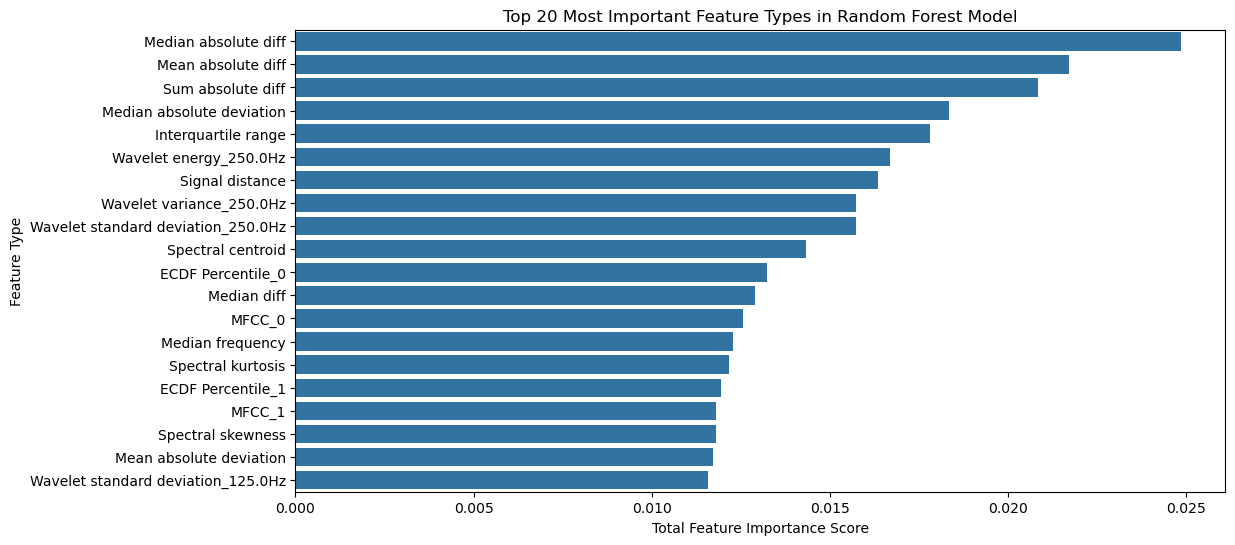

In [47]:
import seaborn as sns

# Plot the top 20 most important general features
plt.figure(figsize=(12, 6))
sns.barplot(x=general_importance_df.Importance[:20], y=general_importance_df["General Feature"][:20])
plt.xlabel("Total Feature Importance Score")
plt.ylabel("Feature Type")
plt.title("Top 20 Most Important Feature Types in Random Forest Model")
plt.show()

In [48]:
# Select only the optimal general features for all channels
selected_columns = [col for col in X_df.columns if any(feature in col for feature in optimal_general_features)]
X_optimized = X_df[selected_columns]

# Print new feature shape
print(f"Reduced Feature Set Shape: {X_optimized.shape}")

Reduced Feature Set Shape: (89321, 224)


In [49]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_optimized, y, test_size=0.2, random_state=42, stratify=y)

# Train Random Forest on reduced feature set
rf_reduced = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf_reduced.fit(X_train, y_train)

RandomForestClassifier(n_jobs=-1, random_state=42)

In [50]:
# Make predictions on training data
y_train_pred = rf_reduced.predict(X_train)

# Compute training accuracy
train_accuracy = accuracy_score(y_train, y_train_pred)
print(f"Training Accuracy: {train_accuracy:.4f}")


# Predict on testing set
y_test_pred = rf_reduced.predict(X_test)

# Compute testing accuracy
test_accuracy = accuracy_score(y_test, y_test_pred)

print(f"Training Accuracy with Dynamically Selected Features: {train_accuracy:.4f}")
print(f"Testing Accuracy: {test_accuracy:.4f}")

Training Accuracy: 1.0000
Training Accuracy with Dynamically Selected Features: 1.0000
Testing Accuracy: 0.9318


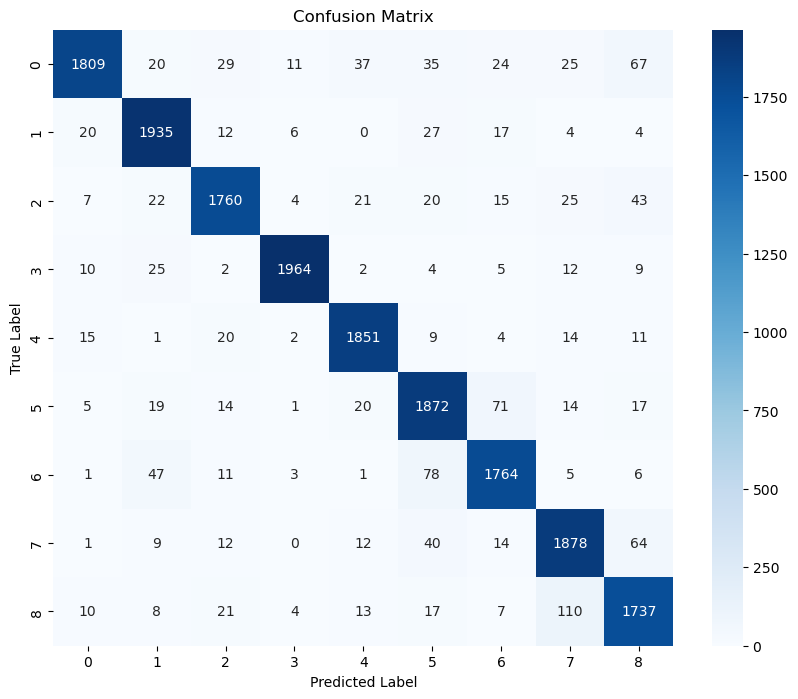

In [51]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=range(9), yticklabels=range(9))
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()